In [2]:
import utils
import pandas as pd
import numpy as np
from nltk import ngrams

In [43]:
utils.PATH = 'bot_app/data/'
utils.PATH

'bot_app/data/'

In [4]:
%%time
qa_df = pd.read_json('../data/ms_marco_large.json')

# expand the answer list
answers_expanded = qa_df.answers.apply(pd.Series)

# rename each variable as answer
answers_expanded = answers_expanded.rename(columns = lambda x : 'answer_' + str(x))
answers_expanded.head()

qa_df = pd.concat([qa_df, answers_expanded], axis=1)

# remove questions without answers
qa_df = qa_df[qa_df.answer_0 != 'No Answer Present.']

# set the answer to the first element of each list
qa_df.answers = qa_df.answer_0

qa_df = qa_df.loc[:, ['answers', 'query']]

utils.save(qa_df, 'qa_df')

ValueError: Could not reserve memory block

In [49]:
qa_df.sample(5)

,answers,query
63059,The dodge and burn Photoshop were used to eith...,what does dodge and burn photoshop do
16724,"An expectorant, amino acid cysteine which is f...",what helps get rid of mucus
24519,The tip size is 000 for Victor torch.,what tip size for victor torch
33865,Related to the mind.,define mentally
44636,Lump sum is a single payment for the total amo...,lump sum payment definition


## Transform the questions into half of the feature space

In [28]:
questions = qa_df.loc[:, 'query']

In [29]:
questions[:10]

0                                  . what is a corporation?
1         why did rachel carson write an obligation to e...
10000                             symptoms of a dying mouse
100000          average number of lightning strikes per day
100001               can you burn your lawn with fertilizer
100007                                         goch meaning
10001                  symptoms of a gastric ulcer in women
100010                        how often can ativan be taken
100012    how many years did william bradford serve as g...
100013                                 albany mn population
Name: query, dtype: object

In [30]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer


In [77]:
# text transformation pipes
clean_text = Pipeline(
    [
        ('stack', FunctionTransformer(utils.stack_questions, validate=False)),
        ('clean', FunctionTransformer(utils.clean_questions, validate=False))

    ]
)

lemma_text = Pipeline(
    [
        ('lemma', FunctionTransformer(utils.apply_lemma, validate=False))
    ]
)

# feature engineering pipes
single_question_pipe = Pipeline(
    [
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False)),
        ('unstack', FunctionTransformer(utils.unstack_questions, validate=False))
    ]
)

pair_question_pipe = Pipeline(
    [
        ('ngram_sim', FunctionTransformer(utils.calc_ngram_similarity, kw_args={'n_grams':[1, 2, 3]}, validate=False))
    ]
)

# build features on the cleaned text only
clean_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ]
        ))
    ]
)

# build features on the cleanned and lemmatized text features
lemma_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('lemma', lemma_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ]
        ))
    ]
)

# pre-process pipe
feature_transformation = Pipeline(
    [
        ('feats', FeatureUnion(
            [
                ('clean_text_features', clean_text_features),
                ('lemma_text_features', lemma_text_features)
            ],
            n_jobs = -1
        ))
    ]
)


In [99]:
X = qa_df.rename(columns={'query':'question1'})
X['id'] = X.index
X['question2'] = 'define mentally'
X = X.drop(columns='answers')
X = X.sort_values('id').reset_index(drop=True)
X.head()

,question1,id,question2
0,. what is a corporation?,0,define mentally
1,why did rachel carson write an obligation to e...,1,define mentally
2,why did the battle of berlin take place,6,define mentally
3,definition of ravines,8,define mentally
4,why did the sumerians develop writing?,11,define mentally


In [100]:
%%time
X_transform = feature_transformation.transform(X)

CPU times: user 127 ms, sys: 239 ms, total: 366 ms
Wall time: 4min 2s


In [101]:
X_transform.shape

(55636, 42)

In [102]:
X_transform[0]

array([ 0.        ,  0.        ,  0.        ,  7.2979822 ,  7.2979822 ,
        7.2979822 ,  0.70618225,  0.70618225,  0.70618225, 99.20149679,
       99.20149679, 99.20149679,  4.37212157,  7.16779371,  5.88214107,
        0.36495314,  0.73614756,  0.56863723, 60.7455775 , 96.1907439 ,
       80.25514047,  0.        ,  0.        ,  0.        ,  7.2979822 ,
        7.2979822 ,  7.2979822 ,  0.70618225,  0.70618225,  0.70618225,
       99.20149679, 99.20149679, 99.20149679,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [103]:
X[X.question1 == 'define mentally']

,question1,id,question2
21959,define mentally,33865,define mentally


In [104]:
X.index.get_loc(21959)

21959

In [105]:
X.iloc[X.index.get_loc(21959)]

question1    define mentally
id                     33865
question2    define mentally
Name: 21959, dtype: object

In [112]:
print(X_transform[21959].shape)
X_transform[21959]

(42,)


array([ 1.        ,  1.        ,  1.        ,  7.2979822 ,  7.2979822 ,
        7.2979822 ,  0.70618225,  0.70618225,  0.70618225, 99.20149679,
       99.20149679, 99.20149679,  7.2979822 ,  7.2979822 ,  7.2979822 ,
        0.70618225,  0.70618225,  0.70618225, 99.20149679, 99.20149679,
       99.20149679,  1.        ,  1.        ,  1.        ,  7.2979822 ,
        7.2979822 ,  7.2979822 ,  0.70618225,  0.70618225,  0.70618225,
       99.20149679, 99.20149679, 99.20149679,  7.2979822 ,  7.2979822 ,
        7.2979822 ,  0.70618225,  0.70618225,  0.70618225, 99.20149679,
       99.20149679, 99.20149679])

In [113]:
xgb.predict_proba(X_transform[21959].reshape(1, -1))[:, 1]

array([0.4627599], dtype=float32)

In [68]:
xgb = utils.load('xgb_FINAL_model_question_swapped')
y_probs = xgb.predict_proba(X_transform)[:,1]

In [76]:
X_ind = X.reset_index()
merge_questions = pd.concat([X_ind, pd.Series(y_probs)], axis=1, sort=False, ignore_index=True)
merge_questions = merge_questions.rename(columns={1:'question1', 3:'question2', 4:'prob'})
merge_questions.sort_values('prob', ascending=False)

,0,question1,2,question2,prob
27923,5254,average propensity to save (aps) definition,5254,define mentally,9.479055e-01
17126,3318,how long do black bear cubs stay with it mother,3318,define mentally,9.475453e-01
32958,61121,is beethoven still alive,61121,define mentally,9.383519e-01
22640,43461,what is a rickshaw,43461,define mentally,9.352981e-01
11529,2478,how can i calculate the square footage,2478,define mentally,9.223383e-01
24106,4596,how many more electrons can fit within the val...,4596,define mentally,9.196010e-01
33291,61713,is the general form of the schrödinger equation?,61713,define mentally,9.029948e-01
14243,28351,who are jordan,28351,define mentally,8.896139e-01
17743,34368,are nightshade seeds deadly,34368,define mentally,8.888130e-01
1219,10976,unlocked iphone x price,10976,define mentally,8.887758e-01


## App data

All data below needs to be pre-calculated

In [39]:
%%time
cleaned_questions = utils.clean_questions(questions)
lemma_questions = utils.apply_lemma(cleaned_questions)

utils.save(cleaned_questions, 'cleaned_questions')
utils.save(lemma_questions, 'lemma_questions')

CPU times: user 41.7 s, sys: 6.86 s, total: 48.6 s
Wall time: 34.6 s


In [40]:
def tokenize_questions(X):
    texts = []
    for doc in utils.nlp.pipe(X, disable=['parser', 'ner'], batch_size=10000):
        texts.append(doc.to_array([utils.spacy.attrs.LOWER]))
    return texts

In [41]:
%%time
clean_tokens = tokenize_questions(cleaned_questions)
lemma_tokens = tokenize_questions(lemma_questions)

utils.save(clean_tokens, 'clean_tokens')
utils.save(lemma_tokens, 'lemma_tokens')

CPU times: user 1min 17s, sys: 11.6 s, total: 1min 28s
Wall time: 1min 4s


In [42]:
%%time
clean_question_features = clean_text_features.transform(questions)
lemma_question_features = lemma_text_features.transform(questions)

utils.save(clean_question_features, 'clean_question_features')
utils.save(lemma_question_features, 'lemma_question_features')

CPU times: user 2min 34s, sys: 14.3 s, total: 2min 48s
Wall time: 1min 51s


In [68]:
xgb = utils.load('xgb_FINAL_model')

In [45]:
def ngram_similarity(q_token, token_db,  n_grams=[1, 2, 3]):
    ''' Calculates the ngram similarity between a pair of questions. Similarity is defined as,
            2 · ( |S1| / |S1 ∩ S2| + |S2| / |S1 ∩ S2|)^−1
        where S_i is the ngrams for question i
        
        n_grams: list
        List of n-grams to calculate, i.e. [1, 2, 3]
        
        return: array-like (n_pairs, len(n_grams))
        N-dimensional array of n_gram similarity calculated for the different n_grams.
        
    '''
    ngram_sim = []
    ngram_q2 = [set(ngrams(q_token, i, pad_right=True)) for i in n_grams]
    for t in token_db:
        ngram_q1 = [set(ngrams(t, i, pad_right=True)) for i in n_grams]

        doc_ngram_sim = []
        for i in range(len(ngram_q1)):
            try:
                s1 = len(ngram_q1[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s1 = 0

            try:
                s2 = len(ngram_q2[i]) / len(ngram_q1[i].intersection(ngram_q2[i]))
            except:
                s2 = 0

            if s1 == 0 and s2 == 0:
                doc_ngram_sim.append(0)
            else:
                doc_ngram_sim.append(2 * (s1 + s2)**-1)
        ngram_sim.append(doc_ngram_sim)
        
    return np.array(ngram_sim)


In [83]:
def ask_question(question):
    
    question_clean = utils.clean_questions([question]) ## returns an array
    ## if question is a duplicate after cleaning, then return the answer
    if question_clean[0] in cleaned_questions:
        return question_clean
    
    ## else run the model
    else:    
        ## Feature Set 1 -- clean text similarity
        ## create the tokens for the question
        doc = utils.nlp(question_clean[0])
        question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
        clean_n_gram = ngram_similarity(question_tokens, clean_tokens)

        ## Feature Set 2 -- Clean distance features
        # union single question features
        question_features = clean_text_features.transform([question]) 
        clean_single_features = np.hstack([clean_question_features, 
                                           np.repeat(question_features, clean_question_features.shape[0], axis=0)])
        

        ## Feature Set 3 -- Lemma text similarity
        # calculate n_gram similarity for the cleaned and lemmatized question
        question_lemma = utils.apply_lemma(question_clean)
        doc = utils.nlp(question_lemma[0])
        question_tokens = doc.to_array([utils.spacy.attrs.LOWER])
        lemma_n_gram = ngram_similarity(question_tokens, lemma_tokens)


        ## Feature Set 4 -- Lemma distance features
        # union single question features
        question_features = lemma_text_features.transform([question]) 
        lemma_single_features = np.hstack([lemma_question_features, 
                                           np.repeat(question_features, lemma_question_features.shape[0], axis=0)])

    ### Transform through the whole pipeline
#     df_cleaned_questions['question2'] = question
    
#     feature_space = feature_pipe.transform(df_cleaned_questions[:5000])

        # make the prediction
        feature_space = np.hstack([clean_n_gram, clean_single_features, lemma_n_gram, lemma_single_features])
        probs = xgb.predict_proba(feature_space)[:, 1]

        top = probs.argsort()[-3:]
        top_question = np.array(qa_df.iloc[top]).reshape(len(top), -1)
        top_probs = probs[top].reshape(-1, 1)

#     return None
#     return pd.DataFrame(np.hstack([top_question, top_probs]))
        return feature_space, pd.DataFrame(np.hstack([top_question, top_probs]))

In [74]:
ask_question('do owls eat in the day')

['do owls eat in the day']

In [64]:
ask_question('do owls eat at night')

(101093, 42)

In [84]:
features, top_results = ask_question('what causes earthquakes')

In [19]:
'do owls eat in the day' in cleaned_questions

True

In [250]:
df[df.question1 == 'do owls eat in the day']

,question1,id,question2
4,do owls eat in the day,4,do owls eat in the day


In [85]:
top_results # full pipeline

,0,1,2,3,4,5,6
0,[No Answer Present.],"[{'is_selected': 0, 'passage_text': 'What is a...",what causes boil water notice,586008,DESCRIPTION,[],0.861625
1,[Humans can cause earthquakes by triggering se...,"[{'is_selected': 0, 'passage_text': 'An uptick...",how can humans cause earthquakes,210161,DESCRIPTION,[],0.863643
2,[Stasis dermatitis cause extremely sensitive a...,"[{'is_selected': 0, 'passage_text': 'Poor circ...",stasis dermatitis causes,1090422,DESCRIPTION,[],0.895012


In [72]:
top_results # opt pipeline

,0,1
0,what causes fingers to swell at night,0.2007
1,what causes swelling in hands at night,0.30395
2,do owls eat in the day,0.408373


In [251]:
features[4]

array([  1.        ,   1.        ,   1.        ,   4.63359628,
         8.4752183 ,   6.82304781,   0.44451424,   0.94712703,
         0.66871357,  62.24226321, 115.15204134,  92.26256858,
         4.63359628,   8.4752183 ,   6.82304781,   0.44451424,
         0.94712703,   0.66871357,  62.24226321, 115.15204134,
        92.26256858,   1.        ,   1.        ,   1.        ,
         6.72955502,   8.34001638,   7.60125726,   0.55986509,
         0.79268708,   0.69988742,  92.72933482, 111.52220958,
       102.69947146,   6.72955502,   8.34001638,   7.60125726,
         0.55986509,   0.79268708,   0.69988742,  92.72933482,
       111.52220958, 102.69947146])

In [214]:
probs = xgb.predict_proba(features)[:, 1]

In [218]:
xgb.predict_proba(features[20546].reshape(1, -1))[:, 1]

array([0.1619365], dtype=float32)

In [216]:
probs[20546]

0.1619365

In [220]:
import matplotlib.pyplot as plt
print(xgb.feature_importances_)

[0.02938479 0.02320101 0.01954768 0.01709631 0.0290843  0.02475091
 0.02119247 0.03724498 0.03382888 0.01341136 0.02718646 0.02229954
 0.01790289 0.02774    0.02487743 0.0211134  0.03670726 0.03213665
 0.0142812  0.02740788 0.02233117 0.02340661 0.01603669 0.01205124
 0.02133481 0.02304286 0.02117666 0.02979598 0.03019137 0.02762929
 0.01991143 0.02397596 0.02027519 0.0207022  0.02217302 0.0199747
 0.02709157 0.03117191 0.02400759 0.01902578 0.02492488 0.01937371]


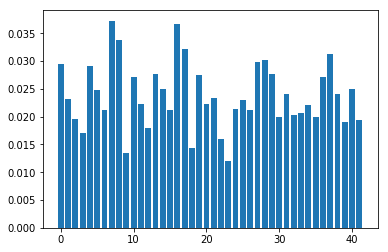

In [221]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

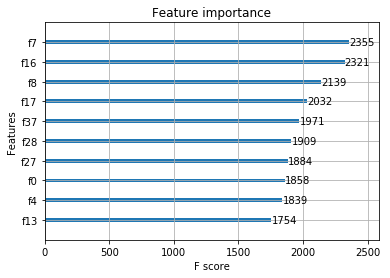

In [240]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=10)
plt.show()

In [236]:
feature_names = [
    'clean_1_gram_sim',
    'clean_2_gram_sim',
    'clean_3_gram_sim',
    'clean_euc_min_q1',
    'clean_euc_max_q1',
    'clean_euc_avg_q1',
    'clean_cos_min_q1',
    'clean_cos_max_q1',
    'clean_cos_avg_q1',
    'clean_man_min_q1',
    'clean_man_max_q1',
    'clean_man_avg_q1',
    'clean_euc_min_q2',
    'clean_euc_max_q2',
    'clean_euc_avg_q2',
    'clean_cos_min_q2',
    'clean_cos_max_q2',
    'clean_cos_avg_q2',
    'clean_man_min_q2',
    'clean_man_max_q2',
    'clean_man_avg_q2',
    'lemma_1_gram_sim',
    'lemma_2_gram_sim',
    'lemma_3_gram_sim',
    'lemma_euc_min_q1',
    'lemma_euc_max_q1',
    'lemma_euc_avg_q1',
    'lemma_cos_min_q1',
    'lemma_cos_max_q1',
    'lemma_cos_avg_q1',
    'lemma_man_min_q1',
    'lemma_man_max_q1',
    'lemma_man_avg_q1',
    'lemma_euc_min_q2',
    'lemma_euc_max_q2',
    'lemma_euc_avg_q2',
    'lemma_cos_min_q2',
    'lemma_cos_max_q2',
    'lemma_cos_avg_q2',
    'lemma_man_min_q2',
    'lemma_man_max_q2',
    'lemma_man_avg_q1'
    
]
print(len(feature_names))

42


In [253]:
def print_features(l=[7, 16, 8, 17, 37, 28, 27, 0, 4, 13]):
    for n in l:
#         print(n)
        print(feature_names[n])
print_features()

clean_cos_max_q1
clean_cos_max_q2
clean_cos_avg_q1
clean_cos_avg_q2
lemma_cos_max_q2
lemma_cos_max_q1
lemma_cos_min_q1
clean_1_gram_sim
clean_euc_max_q1
clean_euc_max_q2


In [238]:
features[20456, [7, 16, 8, 17, 37]]

array([0.96252071, 1.08482914, 0.72458074, 0.68943047, 1.06595845])

In [239]:
xgb.get_booster().get_fscore()

{'f1': 1467,
 'f21': 1480,
 'f0': 1858,
 'f28': 1909,
 'f7': 2355,
 'f29': 1747,
 'f6': 1340,
 'f8': 2139,
 'f12': 1132,
 'f4': 1839,
 'f16': 2321,
 'f2': 1236,
 'f27': 1884,
 'f17': 2032,
 'f39': 1203,
 'f22': 1014,
 'f13': 1754,
 'f18': 903,
 'f10': 1719,
 'f37': 1971,
 'f19': 1733,
 'f23': 762,
 'f38': 1518,
 'f34': 1402,
 'f5': 1565,
 'f24': 1349,
 'f3': 1081,
 'f25': 1457,
 'f32': 1282,
 'f41': 1225,
 'f15': 1335,
 'f35': 1263,
 'f20': 1412,
 'f26': 1339,
 'f31': 1516,
 'f33': 1309,
 'f9': 848,
 'f36': 1713,
 'f30': 1259,
 'f40': 1576,
 'f11': 1410,
 'f14': 1573}

In [ ]:
#### ask_question('What is the capital of Washington?')
# ask_question('noncontagious definition')
ask_question('where is the stamen located in a flower')

In [188]:
qa_df.loc[:, 'query'].sample()

27505    where is the stamen located in a flower
Name: query, dtype: object

In [167]:
p.argsort()[-3:]

array([21032, 80760, 14203])

In [166]:
questions.iloc[p.argsort()[-3:]]
# questions.iloc[1]

27943     which is the original delmonico's
81699               what state is borths in
21797    what is the meaning of the bowery?
Name: query, dtype: object

In [168]:
q_array = np.array(questions)

In [169]:
q_array[14203]

'what is the meaning of the bowery?'

In [170]:
q_array[80760]

'what state is borths in'

In [72]:
q = ['What is the capital of Washington?']

In [76]:
np.repeat(q, 2, axis=0).shape

(2,)

In [108]:
utils.save(token_text, 'questions_tokenized')


In [104]:
for t in token_text:
    print(type(t))
    break

<class 'numpy.ndarray'>


In [97]:
from nltk import ngrams

In [107]:
for n in ngrams(np.array(token_text[0]), 3, pad_right=True):
    print(n)

(8532415787641010193, 5865838185239622912, 3411606890003347522)
(5865838185239622912, 3411606890003347522, 11901859001352538922)
(3411606890003347522, 11901859001352538922, 14070511896034874754)
(11901859001352538922, 14070511896034874754, None)
(14070511896034874754, None, None)


In [111]:
doc = utils.nlp('What is the capital of Washington?')
q_tokens = doc.to_array([utils.spacy.attrs.LOWER])

In [116]:
np.hstack([np.array(token_text).reshape(-1, 1), np.repeat(q_tokens, len(token_text), axis=0).reshape(1, -1)]).shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [117]:
t = np.array(token_text).reshape(-1, 1)

In [118]:
t.shape

(101093, 1)

In [119]:
t

array([[array([ 8532415787641010193,  5865838185239622912,  3411606890003347522,
       11901859001352538922, 14070511896034874754], dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965, 11779693057662023107,
        2619154345045139155, 15597474948775060119, 15099054000809333061,
        1920611397140219205,  3791531372978436496, 13569477888548814854],
      dtype=uint64)],
       [array([16315412628806490806, 13583488448875926965,  7425985699627899538,
       11900862162089982680,  6184037061712818460,  3142894986720291236,
        3791531372978436496, 17339002579355368042,  9095968958430269659,
       10313580197444822952,  9952569212994313472], dtype=uint64)],
       ...,
       [array([16331095434822636218, 12965068231793614765,  3791531372978436496,
        7340758616018961957, 10606469382566443026, 16929211676819693673],
      dtype=uint64)],
       [array([ 3077651023035088716,  6878210874361030284,  3791531372978436496,
       13320680580156776400, 1412212

In [127]:
v = np.repeat(q_tokens, len(token_text))

In [128]:
v.shape

(707651,)

In [124]:
len(token_text)

101093

In [133]:
%%time
ngram_similarity(q_tokens)

CPU times: user 3.62 s, sys: 69 ms, total: 3.69 s
Wall time: 4.64 s


array([[0.33333333, 0.16666667, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.11111111, 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])